In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma as gamma_dist, beta as beta_dist, truncnorm, bernoulli, multinomial, norm

In [2]:
data_count = pd.read_csv("Deng_count.csv", index_col=0)
data_type = pd.read_csv("Deng_celltype.csv", index_col=0)
blast_cells = data_type[data_type['cell_type1'] == 'blast']
blast_counts = data_count.loc[:, blast_cells.index]

p_initial = (data_count == 0).mean(axis=1)
mu_initial = data_count[data_count > 0].mean(axis=1)

np.save("p_array.npy", p_initial.values)
np.save("mu_array.npy", mu_initial.values)

p = np.load("p_array.npy")

X = np.array(blast_counts.copy())

Z = np.zeros(np.shape(X)) 
p = np.load("p_array.npy")
mu = np.load("mu_array.npy")
Z_values = []
mu_values = []
p_values = []
alpha_mu_values = []
beta_mu_values = []
gamma_values = []
beta_values = []

# Gibbs Sampling 
G = X.shape[0]
I = X.shape[1]
print(p)
print(np.shape(p))
print(mu)
print(np.shape(mu))
print(G)

[0.30970149 0.79104478 0.26492537 ... 0.75       0.84701493 0.15671642]
(11394,)
[388.44864865 326.89285714 982.81725888 ...  10.43283582  16.68292683
 342.09734513]
(11394,)
11394


In [ ]:
logit_p = np.log(p / (1 - p))
mu = np.clip(mu, 0.01, None) 
log_mu = np.log(mu)

mean_log_mu = np.mean(log_mu)
mean_logit_p = np.mean(logit_p)

numerator = np.sum((log_mu - mean_log_mu) * (logit_p - mean_logit_p))
denominator = np.sum((log_mu - mean_log_mu) ** 2)

beta = numerator / denominator

gamma = mean_logit_p - beta * mean_log_mu


print(f"Slope (beta): {beta}")
print(f"Intercept (gamma): {gamma}")


import matplotlib.pyplot as plt

plt.scatter(log_mu, logit_p, color='blue', alpha=0.5, label='Data Points')

predicted_logit_p = beta * log_mu + gamma
plt.plot(log_mu, predicted_logit_p, color='red', label=f'Fit Line: {beta:.2f}*x + {gamma:.2f}')

plt.xlabel('log(μ)')
plt.ylabel('logit(p)')
plt.legend()
plt.show()


In [ ]:
def indicator_sampling(X, p, mu):
    G, I = X.shape
    non_zero_indices = np.where(X != 0)
    X_1 = X[non_zero_indices] * 0 
    p_extended = np.broadcast_to(p[:, np.newaxis], (G, I)) 
    mu_extended = np.broadcast_to(mu[:, np.newaxis], (G, I))  
    p = (1 - p_extended) * poisson.pmf(X, mu_extended)  
    p_complement = p_extended  
    normalized_p= np.stack([p, p_complement], axis=-1)  
    sum_p = np.sum(normalized_p, axis=2) 
    normalized_p = normalized_p / sum_p[..., np.newaxis] 
    p = np.clip(p, 0.0001, 0.9999)
    samples = np.apply_along_axis(lambda p: np.random.choice([0, 1], p=p), -1, normalized_p)
    samples[non_zero_indices] = X_1
    return samples


In [ ]:
print(np.shape(Z))
print(np.shape(X))
print(mu)
print(np.shape(mu))
mu_extended = np.tile(mu[:, np.newaxis], (1, I))
print(mu_extended)
print(p)
print(np.shape(p))

# Function for Distribution of Parameters gamma and beta

In [ ]:
def log_posterior_gamma_beta(beta_prime, Z, p, mu, X):
    G, I = X.shape
    mu_extended = np.tile(mu[:, np.newaxis], (1, I))
    p_extended = np.tile(p[:, np.newaxis], (1, I))
    total_ZIP_log_likelihood = 0
    epsilon = 1e-5 
    poisson_probs = np.where(Z == 0, poisson.pmf(X, mu_extended), 0)
    clipped_poisson_probs = np.clip(poisson_probs, epsilon, 1-epsilon)
    
    for g in range(G):
        for i in range(I):
            if Z[g, i] == 0:
                term = np.log((1 - p_extended[g, i]) * clipped_poisson_probs[g, i])

            total_ZIP_log_likelihood += term

    log_prior_beta_prime = gamma_dist.logpdf(beta_prime, a=3, scale=1/5)
    
    return total_ZIP_log_likelihood + log_prior_beta_prime

# Function for Metropolis Hastings Sampling for Hyperpriors gamma and beta

In [ ]:
def metropolis_hastings_gamma_beta(initial_gamma_beta, Z, p, mu, X, iterations, proposal_std):
    samples = np.zeros((iterations, 2))
    current_gamma, current_beta_prime = initial_gamma_beta
    
    current_logpdf = log_posterior_gamma_beta(current_beta_prime, Z, p, mu, X)
    
    for i in range(iterations):
        proposed_gamma, proposed_beta_prime = np.random.normal([current_gamma, current_beta_prime], proposal_std)
        
        if proposed_beta_prime <= 0:
            samples[i] = [current_gamma, current_beta_prime]
            continue

        proposed_logpdf = log_posterior_gamma_beta(proposed_beta_prime, Z, p, mu, X)
        
        acceptance_prob = np.exp(proposed_logpdf - current_logpdf)
        
        if np.random.rand() < acceptance_prob:
            current_gamma, current_beta_prime = proposed_gamma, proposed_beta_prime
            current_logpdf = proposed_logpdf
            
        samples[i] = [current_gamma, current_beta_prime]
    return samples

# Function for Distribution of Parameters alpha_mu and beta_mu

In [ ]:
def sampling_distribution_alpha_mu_beta_mu(alpha_mu, beta_mu, mu):
    c = 1/np.sqrt(G)
    lamb = 2/3
    log_alpha_mu_beta_mu = gamma_dist.logpdf(alpha_mu, c, scale=lamb)
    log_mu_given_alpha_mu_beta_mu = np.sum(gamma_dist.logpdf(mu, alpha_mu, scale=1/beta_mu))
    log_posterior = log_mu_given_alpha_mu_beta_mu + log_alpha_mu_beta_mu
    return log_posterior

# Function for Metropolis Hastings Sampling for Hyperpriors alpha_mu and beta_mu

In [ ]:
def metropolis_hastings_alpha_mu_beta_mu(mu, initial_alpha_mu_beta_mu, iterations, proposal_std):
    samples = np.zeros((iterations, 2))
    current_alpha_mu, current_beta_mu = initial_alpha_mu_beta_mu
    
    current_logpdf = sampling_distribution_alpha_mu_beta_mu(current_alpha_mu, current_beta_mu, mu)
    
    for i in range(iterations):
        proposed_alpha_mu, proposed_beta_mu = np.random.normal([current_alpha_mu, current_beta_mu], proposal_std)

        if proposed_alpha_mu <= 0 or proposed_beta_mu <= 0:
            samples[i] = [current_alpha_mu, current_beta_mu]
            continue
        
        proposed_logpdf = sampling_distribution_alpha_mu_beta_mu(proposed_alpha_mu, proposed_beta_mu, mu)
        
        acceptance_prob = np.exp(proposed_logpdf - current_logpdf)

        
        if np.random.rand() < acceptance_prob:
            current_alpha_mu = proposed_alpha_mu
            current_beta_mu = proposed_beta_mu
            current_logpdf = proposed_logpdf
            
        samples[i] = [current_alpha_mu, current_beta_mu]
    
    return samples

# Function for mu parameter Sampling

In [ ]:
# def log_posterior_mu_sampling(mu, X, p, k, theta, Z):
#     G, I = X.shape
#     mu_extended = np.tile(mu[:, np.newaxis], (1, I))
#     p_extended = np.tile(p[:, np.newaxis], (1, I))
#     total_ZIP_log_likelihood = 0
#     epsilon = 1e-5 

#     poisson_probs = np.where(Z == 0, poisson.pmf(X, mu_extended), 0)
#     clipped_poisson_probs = np.clip(poisson_probs, epsilon, 1-epsilon)
    
#     for g in range(G):
#         for i in range(I):
#             if Z[g, i] == 0:
#                 term = np.log((1 - p_extended[g, i]) * clipped_poisson_probs[g, i])
#             else:
#                 term = np.log(p_extended[g, i] * clipped_poisson_probs[g, i])

#             total_ZIP_log_likelihood += term

#     log_mu_given_k_theta = np.sum(gamma_dist.logpdf(mu, k, scale=1/theta))

#     log_posterior = total_ZIP_log_likelihood + log_mu_given_k_theta

#     return log_posterior

# Function for Metropolis Hastings mu parameter Sampling

In [ ]:
# def metropolis_hastings_gamma_sampling(initial_mu, X, Z, p, k, theta, iterations, proposal_std):
#     samples = np.zeros((iterations, 1))
#     current_mu = initial_mu
#     print(np.shape(current_mu))
    
#     current_logpdf = log_posterior_mu_sampling(current_mu, X, p, k, theta, Z)
#     print(np.shape(current_logpdf))
    
#     proposed_mu = np.zeros_like(current_mu)
#     print(proposed_mu)
#     print(np.shape(proposed_mu))

#     for j in range(iterations):
#         for i in range(len(current_mu)):
#             proposed_mu[i] = np.random.normal(current_mu[i], proposal_std)
            
#             # This should handle a single mu at a time if your function expects that
#             proposed_logpdf = log_posterior_mu_sampling(proposed_mu, X, p, k, theta, Z)
            
#             acceptance_prob = np.exp(proposed_logpdf - current_logpdf)

#             if np.random.rand() < acceptance_prob:
#                 current_mu[i] = proposed_mu[i]
#                 current_logpdf = proposed_logpdf  # Update if you're considering vector updates

#             samples[j, i] = current_mu[i]  # Store the current value of mu

#     return samples

In [ ]:
def p_calculation(mu, gamma, beta):
    # Calculate the argument of the exponential function
    argument = gamma + beta * np.log(mu)
    
    # Use the logistic function to compute p
    p = 1 / (1 + np.exp(-argument))

    return p

# Gibbs Sampling for Everything

In [ ]:
burn_in = 15
for i in range(100): 
    Z = indicator_sampling(X, p, mu)
    Z_values.append(Z) 

    # # Gamma distribution for gamma and beta
    alpha_mu = 0.2025
    beta_mu = 0.0005037
    initial_gamma = 3.179
    initial_beta = -0.6266
    initial_beta_prime = -initial_beta
    initial_gamma_beta = [initial_gamma, initial_beta_prime]
    proposal_std = [initial_gamma/10, initial_beta_prime/100] 
    iterations = 100
    samples = metropolis_hastings_gamma_beta(initial_gamma_beta, Z, p, mu, X, iterations, proposal_std)
    gamma = samples[iterations-1, 0]
    beta_prime = samples[iterations-1, 1]
    beta = -beta_prime


    # Gamma distribution for alpha_mu and beta_mu
    initial_gamma_sampling = [alpha_mu, beta_mu]
    proposal_std = [0.01/10, 10**(-5)] 
    iterations = 100
    samples = metropolis_hastings_alpha_mu_beta_mu(mu, initial_gamma_sampling, iterations, proposal_std)
    alpha_mu = samples[iterations-1, 0]
    beta_mu = samples[iterations-1, 1]

    c_values = []
    d_values = []
    for g in range(G):
        c = np.dot(X[g], 1-Z[g])
        d = np.sum(Z[g, :] == 0)
        c_values.append(c)
        d_values.append(d)
        mu[g] = np.random.gamma(alpha_mu + c, scale=1/(beta_mu + d))
    
    p = p_calculation(mu, gamma, beta)

    if i >= burn_in:
        alpha_mu_values.append(alpha_mu)
        beta_mu_values.append(beta_mu)
        gamma_values.append(gamma)
        beta_values.append(beta)
        p_values.append(p.copy()) 
        mu_values.append(mu.copy()) 

    print("Completed iteration", i)


In [ ]:
# np.save('mu_values.npy', mu_values)        
# np.save('p_values.npy', p_values)       
# np.save('alpha_mu_values.npy', alpha_mu_values) 
# np.save('beta_mu_values.npy', beta_mu_values)  
# np.save('gamma_values.npy', gamma_values)         
# np.save('beta_values.npy', beta_values) 

In [3]:
mu_values = np.load('mu_values.npy')
p_values = np.load('p_values.npy')
alpha_mu_values = np.load('alpha_mu_values.npy')
beta_mu_values = np.load('beta_mu_values.npy')
gamma_values = np.load('gamma_values.npy')
beta_values = np.load('beta_values.npy')

[[1.78188757e+02 7.56470222e+00 2.26299991e+02 ... 1.39672210e+00
  1.20984578e+00 4.64101526e+02]
 [1.77732695e+02 7.20509865e+00 2.28743225e+02 ... 1.52623866e+00
  8.53420011e-01 4.67477635e+02]
 [1.73760075e+02 5.03901217e+00 2.29651545e+02 ... 1.46206234e+00
  2.06956438e+00 4.69526964e+02]
 ...
 [1.77278623e+02 4.79728192e+00 2.27154662e+02 ... 1.35067740e+00
  7.38259575e-01 4.65389692e+02]
 [1.78855028e+02 1.09823539e+00 2.25475000e+02 ... 3.71453581e-01
  1.69712377e-01 4.65879286e+02]
 [1.77465932e+02 7.50700486e+00 2.25333650e+02 ... 1.85659163e+00
  1.40661334e+00 4.64319544e+02]]
(85, 11394)
[[0.40720474 0.82321968 0.37277657 ... 0.9283547  0.93393062 0.27779715]
 [0.99871474 0.99981088 0.99850567 ... 0.99992525 0.9999472  0.99771029]
 [0.03410984 0.25545401 0.02867684 ... 0.43165978 0.37795317 0.0183095 ]
 ...
 [0.00313388 0.02674934 0.00270147 ... 0.05557618 0.07798984 0.00175754]
 [0.99661755 0.99986656 0.99608332 ... 0.99993299 0.99995926 0.99380297]
 [0.69849996 0.937

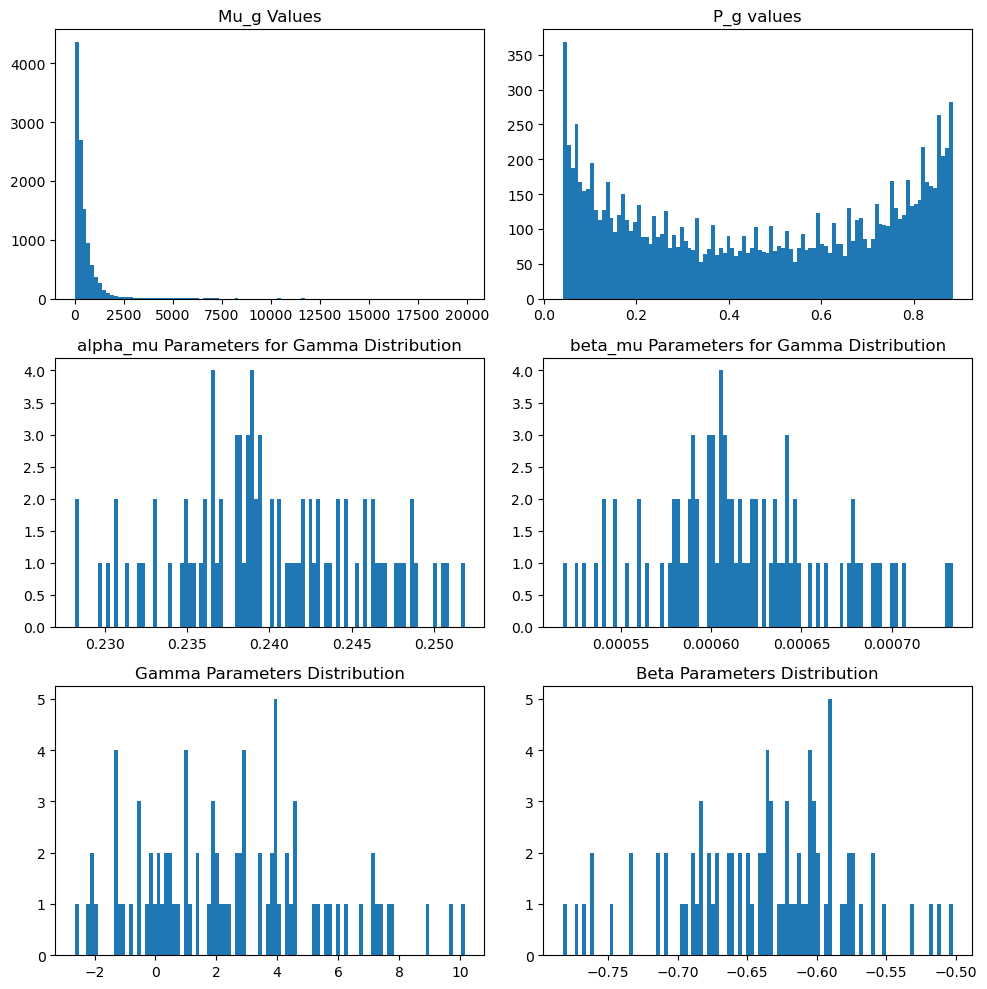

In [4]:
print(mu_values)
print(np.shape(mu_values))
print(p_values)
print(np.shape(p_values))
print(alpha_mu_values)
print(beta_mu_values)
print(gamma_values)
print(beta_values)


fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0, 0].hist(mu[30:], 100)
axs[0, 0].set_title("Mu_g Values")
axs[0, 1].hist(p[30:], 100)
axs[0, 1].set_title("P_g values")
axs[1, 0].hist(alpha_mu_values, 100)
axs[1, 0].set_title("alpha_mu Parameters for Gamma Distribution")
axs[1, 1].hist(beta_mu_values, 100)
axs[1, 1].set_title("beta_mu Parameters for Gamma Distribution")
axs[2, 0].hist(gamma_values, 100)
axs[2, 0].set_title("Gamma Parameters Distribution")
axs[2, 1].hist(beta_values, 100)
axs[2, 1].set_title("Beta Parameters Distribution")
plt.tight_layout()
plt.show()

In [15]:
print(f"Mean of mu: {np.mean(mu)}")
print(f"Mean of p: {np.mean(p)}")
print(f"Mean of alpha_mu: {np.mean(alpha_mu_values)}")
print(f"Mean of beta_mu: {np.mean(beta_mu_values)}")
print(f"Mean of gamma: {np.mean(gamma_values)}")
print(f"Mean of beta: {np.mean(beta_values)}")

Mean of mu: 331.7833484944705
Mean of p: 0.6923537290478575
Mean of alpha_mu: 0.2400160683820293
Mean of beta_mu: 0.0006165664739332109
Mean of gamma: 2.5139263429667285
Mean of beta: -0.6378832831099189


In [6]:
print(f"Standard Deviation of alpha_mu: {np.std(alpha_mu_values)}")
print(f"Standard Deviation of beta_mu: {np.std(beta_mu_values)}")
print(f"Standard Deviation of gamma: {np.std(gamma_values)}")
print(f"Standard Deviation of beta: {np.std(beta_values)}")


Standard Deviation of alpha_mu: 0.005552501719685396
Standard Deviation of beta_mu: 4.6868242944329644e-05
Standard Deviation of gamma: 2.9460024924111448
Standard Deviation of beta: 0.05989340175703362


In [17]:
mu = mu_values[-1]
p = p_values[-1]

In [18]:
initial_data_mean = data_count.mean().mean()

initial_zero_probability = (data_count == 0).mean().mean()

def compute_posterior_predictive_stats(p, mu):
    predictive_mean = np.mean(mu)
    predictive_zero_prob = np.mean(p)
    return predictive_mean, predictive_zero_prob

def check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability, tolerance_mean = 30, tolerance_prob=0.1):
    predictive_mean, predictive_zero_prob = compute_posterior_predictive_stats(p, mu)
    mean_diff = abs(predictive_mean - initial_data_mean)
    zero_prob_diff = abs(predictive_zero_prob - initial_zero_probability)
    print(f"The model's prediction for the mean is: {predictive_mean}")
    print(f"The model's prediction for the zero probability is: {predictive_zero_prob}")
    print(initial_data_mean)
    print(initial_zero_probability)
    if mean_diff < tolerance_mean and zero_prob_diff < tolerance_prob:
        print("Convergence likely achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")
    else:
        print("Convergence not yet achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")

check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability)

The model's prediction for the mean is: 332.13043927883353
The model's prediction for the zero probability is: 0.6923537290478575
332.0669784961449
0.4643564038679693
Convergence not yet achieved.
Predictive Mean Difference: 0.06346078268865085, Predictive Zero Probability Difference: 0.22799732517988824


In [21]:
G = data_count.shape[0]
N0 = blast_counts.shape[1]

# Initial data mean
initial_data_mean = blast_counts.mean().mean()

# Probability that the data is 0
initial_zero_probability = (blast_counts == 0).mean().mean()

def compute_posterior_predictive_stats(p, mu):
    predictive_mean = np.mean(mu * (1 - p))
    predictive_zero_prob = np.mean(p + (1 - p) * np.exp(-mu))
    return predictive_mean, predictive_zero_prob

def check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability, tolerance_mean = 30, tolerance_prob=0.01):
    predictive_mean, predictive_zero_prob = compute_posterior_predictive_stats(p, mu)
    mean_diff = abs(predictive_mean - initial_data_mean)
    zero_prob_diff = abs(predictive_zero_prob - initial_zero_probability)
    print(f"The model's prediction for the mean is: {predictive_mean}")
    print(f"The model's prediction for the zero probability is: {predictive_zero_prob}")
    print(initial_data_mean)
    print(initial_zero_probability)
    if mean_diff < tolerance_mean and zero_prob_diff < tolerance_prob:
        print("Convergence likely achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")
    else:
        print("Convergence not yet achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")

check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability)

The model's prediction for the mean is: 158.96271213037804
The model's prediction for the zero probability is: 0.6926612906495588
253.64257800900356
0.4962412613946663
Convergence not yet achieved.
Predictive Mean Difference: 94.67986587862552, Predictive Zero Probability Difference: 0.19642002925489255
